In [1]:
import numpy as np
import matplotlib.pyplot as plt

import numdifftools as nd
from scipy.interpolate import interp1d

In [2]:
import modules.plots.deconvolution as dec_plots
import modules.experimental_rir as exprir
from modules import randomized_ir, utils, mcmc, adc

from modules_reloader import reloader
relmod = reloader(dec_plots, exprir, randomized_ir, utils, mcmc, adc)

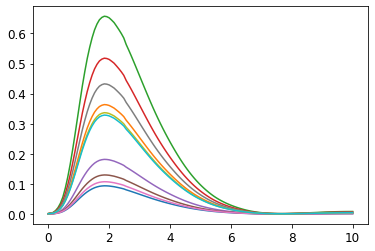

In [3]:
ir_t, ir_shape = exprir.read_ir_shape()
ir_t, ir_shape = exprir.cut_ir_shape(ir_t, ir_shape, excluded_integral_percentile=0.02)

rir = randomized_ir.RandomizedIr(ir_x=ir_t, ir_y=ir_shape, factor=exprir.generate_C_pmt)
L = rir.L

rir.plot_realizations()

In [4]:
N = 35

n_vec_lambda = 20
n_vec = utils.generate_poissonian_ns(n_vec_lambda, N)

# injecting fake signal in 3 central bins
n_vec[ N//2-1 : N//2+2  ] += 2*n_vec_lambda

adc_step = 2.0

s_vec = adc.adc_accepted_s_vec(rir.convolve_with_n_vec(n_vec), adc_step)

In [5]:
rireff = randomized_ir.RandomizedIrEffect(rir, N, samplesize=10**6)

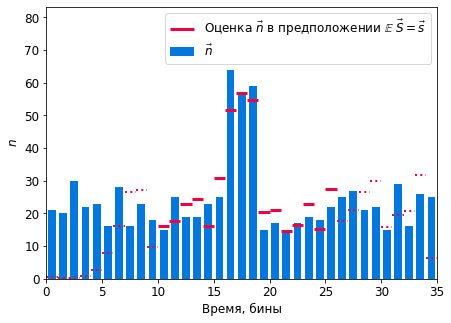

In [6]:
n_vec_estimation = rireff.estimate_n_vec(s_vec, delta=adc_step)
f, a = dec_plots.plot_mean_n_estimation(n_vec, n_vec_estimation, L)

In [7]:
ll_fact = rireff.get_loglikelihood_independent_normdist(s_vec, delta=adc_step, density=False)
ll_fact(n_vec_estimation)  # let the numba do the trick
ll_mvn_density = rireff.get_loglikelihood_mvn(s_vec, delta=adc_step, density=True)
ll_mvn = rireff.get_loglikelihood_mvn(s_vec, delta=adc_step, density=False)

In [8]:
for ll_timed in [utils.timer(lambda *a, **kw: '')(ll) for ll in (ll_fact, ll_mvn_density, ll_mvn)]:
    print(ll_timed(n_vec_estimation))

loglikelihood_normdist() took 1.0454001312609762e-05 seconds to complete.
-22.350985700288906
loglikelihood_mvn() took 0.00115133699728176 seconds to complete.
-26.6517532948836
loglikelihood_mvn() took 0.006181771001138259 seconds to complete.
-13.886945612559613


In [9]:
relmod()

In [10]:
result_preliminary = mcmc.run_mcmc(
    logposterior=ll_fact,
    init_point=n_vec_estimation,
    L=L,
    config=mcmc.SamplingConfig(
        n_walkers=128,
        n_samples=20000,
        progress_bar=True,
        # autocorr_estimation_each=3000,
        # debug_acceptance_fraction_each=500,
    ) 
)

100%|██████████| 20000/20000 [00:14<00:00, 1335.08it/s]


In [11]:
tau = result_preliminary.sampler.get_autocorr_time(quiet=True).mean()

N/50 = 400;
tau: [2370.66664998 2435.99528774 2415.90413465 2354.91607159 1862.77455545
 1437.85387139 1476.97654037 1747.85945332 1692.78327051 1634.93805835
 1521.15049868 1525.84311274 1447.151636   1568.89915922 1519.79163577
 1424.15777015 1399.234998   1434.05357513 1418.84659696 1436.3473276
 1434.5617835  1477.74307032 1511.89265922 1552.2849523  1510.98854584
 1536.62936506 1503.54166745 1425.88732544 1463.10551804 1499.59457889
 1396.14075565 1458.37926519 1441.34377369 1732.08029586 1782.9140867 ]


In [12]:
n_walkers_final = 128

init_pts = mcmc.extract_independent_sample(result_preliminary.sampler, desired_sample_size=n_walkers_final)

In [13]:
result = mcmc.run_mcmc(
    logposterior=ll_mvn,
    init_point=init_pts,
    L=L,
    config=mcmc.SamplingConfig(
        n_walkers=n_walkers_final,
        n_samples=4 * tau,
        progress_bar=True,
        starting_points_strategy='given',
    )
)

100%|██████████| 6497/6497 [16:19<00:00,  6.64it/s]


In [16]:
sample_preliminary = mcmc.extract_independent_sample(result_preliminary.sampler, tau_override=tau, debug=True)
sample = mcmc.extract_independent_sample(result.sampler, tau_override=tau, debug=True)

Autocorrelation time is estimated at 1624.3780527642812 (ranges from 1624.3780527642812 to 1624.3780527642812)
Burn-in = 3248 samples
Thinning = 1461 samples
Autocorrelation time is estimated at 1624.3780527642812 (ranges from 1624.3780527642812 to 1624.3780527642812)
Burn-in = 3248 samples
Thinning = 1461 samples


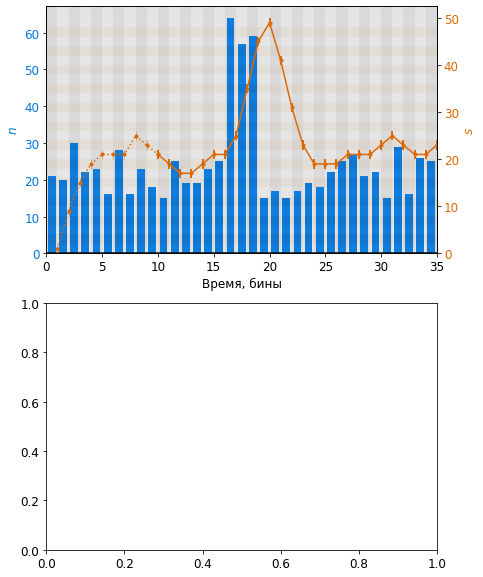

/home/njvh/Documents/Science/sphere/thesis/modules/plots/deconvolution.py:212: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolormesh(


In [24]:
fig_conv_solution, (ax_conv, ax_solution) = plt.subplots(nrows=2, figsize=dec_plots.Figsize.TWOPANEL_VERT.value)

dec_plots.plot_convolution(
    n_vec=n_vec, s_vec=s_vec, delta=adc_step,
    fig_ax=(fig_conv_solution, ax_conv), end_x_axis_on_N=True,
)

dec_plots.plot_bayesian_mean_estimation(n_vec, sample, L, n_vec_estimation, fig_ax=(fig_conv_solution, ax_solution))

fig_conv_solution.savefig('../doc/pic/final-problem-and-solution.pdf')

(<Figure size 504x360 with 1 Axes>, <AxesSubplot:xlabel='$n_{10}$'>)

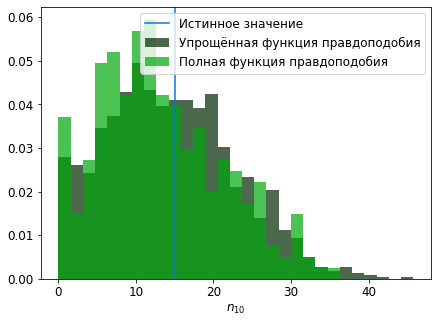

In [26]:
dec_plots.plot_bayesian_mean_estimation_in_bin(
    n_vec,
    [sample_preliminary, sample],
    ['Упрощённая функция правдоподобия', 'Полная функция правдоподобия'],
    10,
    filename=None  # 'simplified-and-true-likelihood-comparison'
)